In [ ]:
!pip install medmnist torch torchvision matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

100%|██████████| 560k/560k [00:00<00:00, 718kB/s]


Train: 546 imágenes
Validación: 78 imágenes
Test: 156 imágenes
Entrenando modelos individuales...

1. Entrenando SimpleCNN...
Epoch [1/15], Loss: 0.5832, Val Acc: 73.08%
Epoch [6/15], Loss: 0.5025, Val Acc: 80.77%
Epoch [11/15], Loss: 0.4615, Val Acc: 82.05%

2. Entrenando DeepCNN...
Epoch [1/15], Loss: 0.6297, Val Acc: 73.08%
Epoch [6/15], Loss: 0.5297, Val Acc: 73.08%
Epoch [11/15], Loss: 0.5054, Val Acc: 76.92%

3. Entrenando ResNetLike...
Epoch [1/15], Loss: 0.5910, Val Acc: 73.08%
Epoch [6/15], Loss: 0.5327, Val Acc: 76.92%
Epoch [11/15], Loss: 0.4975, Val Acc: 75.64%

EVALUACIÓN DE MODELOS
SimpleCNN: 0.7692
DeepCNN: 0.7436
ResNetLike: 0.7628
Ensemble (Promedio): 0.7628
Ensemble (Votación): 0.7628


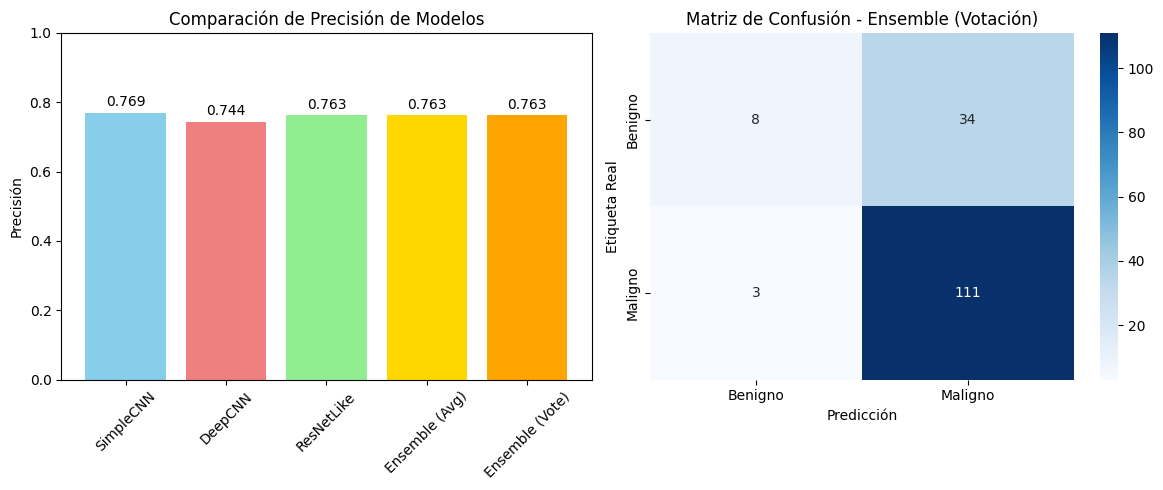


--------------------------------------------------
REPORTE DETALLADO DEL MEJOR ENSAMBLE
--------------------------------------------------
Método: Votación
Precisión: 0.7628

Reporte de clasificación:
              precision    recall  f1-score   support

     Benigno       0.73      0.19      0.30        42
     Maligno       0.77      0.97      0.86       114

    accuracy                           0.76       156
   macro avg       0.75      0.58      0.58       156
weighted avg       0.76      0.76      0.71       156


--------------------------------------------------
ANÁLISIS DE DIVERSIDAD
--------------------------------------------------
Diversidad del ensamble: 0.0513
(Proporción de desacuerdos entre modelos)

--------------------------------------------------
RESUMEN FINAL
--------------------------------------------------
Mejor modelo individual: ('SimpleCNN', 0.7692307692307693)
Mejor ensamble: Ensemble (Votación) - 0.7628
Mejora del ensamble: +-0.0064 (-0.64%)


In [ ]:
import medmnist
from medmnist import INFO, BreastMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict
import random

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configuración del dataset
data_flag = 'breastmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Transformaciones con aumentación de datos para diversidad en el ensamble
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.3),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar datasets
train_dataset = DataClass(split='train', transform=transform_train, download=download)
val_dataset = DataClass(split='val', transform=transform_test, download=download)
test_dataset = DataClass(split='test', transform=transform_test, download=download)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print(f'Train: {len(train_dataset)} imágenes')
print(f'Validación: {len(val_dataset)} imágenes')
print(f'Test: {len(test_dataset)} imágenes')

# Definir múltiples arquitecturas para el ensamble
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = torch.relu(self.conv1(x))
        x = self.conv2(x)
        x += residual
        return torch.relu(x)

class ResNetLike(nn.Module):
    def __init__(self):
        super(ResNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.res_block1 = ResidualBlock(16, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.res_block1(x)
        x = self.pool(x)
        x = self.res_block2(x)
        x = self.adaptive_pool(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Función de entrenamiento
def train_model(model, train_loader, val_loader, epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)

        scheduler.step()

        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%')

    return model, train_losses, val_accuracies

# Clase para el ensamble
class ModelEnsemble:
    def __init__(self, models):
        self.models = models
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def predict_proba(self, data_loader):
        """Obtiene probabilidades promedio de todos los modelos"""
        all_probs = []

        for model in self.models:
            model.eval()
            model_probs = []

            with torch.no_grad():
                for images, _ in data_loader:
                    images = images.to(self.device)
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    model_probs.append(probs.cpu().numpy())

            all_probs.append(np.vstack(model_probs))

        # Promedio de probabilidades
        ensemble_probs = np.mean(all_probs, axis=0)
        return ensemble_probs

    def predict(self, data_loader):
        """Predicciones del ensamble"""
        probs = self.predict_proba(data_loader)
        return np.argmax(probs, axis=1)

    def vote_predict(self, data_loader):
        """Votación por mayoría"""
        all_predictions = []

        for model in self.models:
            model.eval()
            model_preds = []

            with torch.no_grad():
                for images, _ in data_loader:
                    images = images.to(self.device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    model_preds.append(predicted.cpu().numpy())

            all_predictions.append(np.hstack(model_preds))

        # Votación por mayoría
        ensemble_preds = []
        for i in range(len(all_predictions[0])):
            votes = [preds[i] for preds in all_predictions]
            ensemble_preds.append(max(set(votes), key=votes.count))

        return np.array(ensemble_preds)

# Entrenar múltiples modelos
print("Entrenando modelos individuales...")
models = []
model_names = ['SimpleCNN', 'DeepCNN', 'ResNetLike']

# Modelo 1: SimpleCNN
print("\n1. Entrenando SimpleCNN...")
model1 = SimpleCNN()
model1, _, _ = train_model(model1, train_loader, val_loader, epochs=15)
models.append(model1)

# Modelo 2: DeepCNN
print("\n2. Entrenando DeepCNN...")
model2 = DeepCNN()
model2, _, _ = train_model(model2, train_loader, val_loader, epochs=15, lr=0.0005)
models.append(model2)

# Modelo 3: ResNetLike
print("\n3. Entrenando ResNetLike...")
model3 = ResNetLike()
model3, _, _ = train_model(model3, train_loader, val_loader, epochs=15)
models.append(model3)

# Crear ensamble
ensemble = ModelEnsemble(models)

# Obtener etiquetas verdaderas del conjunto de prueba
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.squeeze().numpy())
true_labels = np.array(true_labels)

# Evaluar modelos individuales y ensamble
print("\n" + "="*50)
print("EVALUACIÓN DE MODELOS")
print("="*50)

results = {}

# Evaluar cada modelo individual
for i, (model, name) in enumerate(zip(models, model_names)):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    results[name] = accuracy
    print(f"{name}: {accuracy:.4f}")

# Evaluar ensamble con promedio de probabilidades
ensemble_pred_avg = ensemble.predict(test_loader)
ensemble_acc_avg = accuracy_score(true_labels, ensemble_pred_avg)
results['Ensemble (Avg)'] = ensemble_acc_avg
print(f"Ensemble (Promedio): {ensemble_acc_avg:.4f}")

# Evaluar ensamble con votación
ensemble_pred_vote = ensemble.vote_predict(test_loader)
ensemble_acc_vote = accuracy_score(true_labels, ensemble_pred_vote)
results['Ensemble (Vote)'] = ensemble_acc_vote
print(f"Ensemble (Votación): {ensemble_acc_vote:.4f}")

# Visualizar resultados
plt.figure(figsize=(12, 5))

# Gráfico de barras con precisiones
plt.subplot(1, 2, 1)
names = list(results.keys())
accuracies = list(results.values())
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange']

bars = plt.bar(names, accuracies, color=colors[:len(names)])
plt.title('Comparación de Precisión de Modelos')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.ylim([0, 1])

# Agregar valores en las barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Matriz de confusión para el mejor ensamble
best_ensemble_pred = ensemble_pred_avg if ensemble_acc_avg > ensemble_acc_vote else ensemble_pred_vote
best_method = "Promedio" if ensemble_acc_avg > ensemble_acc_vote else "Votación"

plt.subplot(1, 2, 2)
cm = confusion_matrix(true_labels, best_ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Maligno'],
            yticklabels=['Benigno', 'Maligno'])
plt.title(f'Matriz de Confusión - Ensemble ({best_method})')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')

plt.tight_layout()
plt.show()

# Reporte detallado
print(f"\n{'-'*50}")
print("REPORTE DETALLADO DEL MEJOR ENSAMBLE")
print(f"{'-'*50}")
print(f"Método: {best_method}")
print(f"Precisión: {max(ensemble_acc_avg, ensemble_acc_vote):.4f}")
print("\nReporte de clasificación:")
class_names = ['Benigno', 'Maligno']
print(classification_report(true_labels, best_ensemble_pred, target_names=class_names))

# Análisis de diversidad del ensamble
print(f"\n{'-'*50}")
print("ANÁLISIS DE DIVERSIDAD")
print(f"{'-'*50}")

# Obtener predicciones individuales
individual_preds = []
for model in models:
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    individual_preds.append(predictions)

# Calcular diversidad (desacuerdo entre modelos)
disagreements = 0
total_comparisons = 0
for i in range(len(individual_preds)):
    for j in range(i+1, len(individual_preds)):
        disagreements += np.sum(np.array(individual_preds[i]) != np.array(individual_preds[j]))
        total_comparisons += len(individual_preds[i])

diversity = disagreements / total_comparisons
print(f"Diversidad del ensamble: {diversity:.4f}")
print(f"(Proporción de desacuerdos entre modelos)")

print(f"\n{'-'*50}")
print("RESUMEN FINAL")
print(f"{'-'*50}")
print(f"Mejor modelo individual: {max(results.items(), key=lambda x: x[1] if 'Ensemble' not in x[0] else 0)}")
print(f"Mejor ensamble: Ensemble ({best_method}) - {max(ensemble_acc_avg, ensemble_acc_vote):.4f}")
mejora = max(ensemble_acc_avg, ensemble_acc_vote) - max([acc for name, acc in results.items() if 'Ensemble' not in name])
print(f"Mejora del ensamble: +{mejora:.4f} ({mejora*100:.2f}%)")